# Permutation testing
Null: there is no relationship between location of flares and the CA minority population ('MINORPOP').
Alt: there is a relationship between flare location and the CA minority population.

Statistic: difference in proportion of MINORPOP within a 5km buffer of any flare versus the MINORPOP proportion outside the flares buffer.

1) Calculate the actual test statistic  
2) Randomize the flares location, restricted to only CA  
3) Calculate buffer zones  
4) Overlay the block groups with the new buffers  
5) Calculate the statistics based on the new overlay  
6) Put stats into a new df for storage
7) visualize the stats with a density plot

In [77]:
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from pprint import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly
import folium

In [78]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

### Read in file, setup

In [79]:
df = pd.read_csv("data/bgformodel_permutation.csv")
#df = gp.GeoDataFrame(a, geometry='geometry')
# meters_crs = 3310
# df = df.set_crs(meters_crs)

In [80]:
df['MINORPOP_bg_totprop'] = df['MINORPOP'] / df['ACSTOTPOP']

In [81]:
# NOTE setup / testing using random numbers and proportions

# add the column of random proportions to the dataframe
df['buffer_present'] = np.random.randint(2, size=len(df))
df['intersect_prop'] = np.random.rand(len(df))
df.loc[df['buffer_present'] == 0, 'intersect_prop'] = 0
df['intersect_area'] = df['intersect_prop'] * df['Shape_Area']

In [82]:
df.head(10)

,Unnamed: 0,ID,CNTY_NAME,Shape_Area,ACSTOTPOP,UNDER5,OVER64,MINORPOP,LOWINCOME,D_PM25_2,geometry,MINORPOP_bg_totprop,buffer_present,intersect_prop,intersect_area
0,0,60376500012,Los Angeles County,"406,992.50",864,92,154,576,42,34.33,"POLYGON ((-118.326488 33.882821, -118.32541 33...",0.67,1,0.80,"325,919.57"
1,1,60376500014,Los Angeles County,"433,085.47",748,0,162,646,80,46.59,"POLYGON ((-118.326469 33.879784, -118.326469 3...",0.86,1,0.79,"342,008.09"
2,2,60376503002,Los Angeles County,"596,582.85",1149,39,380,895,105,41.34,"POLYGON ((-118.352498 33.87249, -118.352497 33...",0.78,1,0.56,"332,572.14"
3,3,60376503003,Los Angeles County,"337,788.70",1615,30,112,1244,335,46.44,"POLYGON ((-118.352463 33.868478, -118.352462 3...",0.77,0,0.00,0.00
4,4,60376503005,Los Angeles County,"1,066,182.90",1102,92,230,838,204,44.91,"POLYGON ((-118.358956 33.865542, -118.358832 3...",0.76,0,0.00,0.00
5,5,60590111012,Orange County,"602,123.66",1620,231,150,1219,251,44.01,"POLYGON ((-117.94992 33.85927, -117.949296 33....",0.75,0,0.00,0.00
6,6,60374081331,Los Angeles County,"486,467.38",1212,57,150,1055,153,48.34,"POLYGON ((-117.911775 34.026652, -117.911557 3...",0.87,1,0.32,"156,969.33"
7,7,60730101073,San Diego County,"397,431.06",2127,29,402,1923,564,46.77,"POLYGON ((-117.08409 32.580132, -117.083882 32...",0.90,1,0.49,"194,286.03"
8,8,60730101101,San Diego County,"750,923.76",1833,165,88,1608,604,47.67,"POLYGON ((-117.092759 32.577117, -117.092736 3...",0.88,1,0.58,"437,775.25"
9,9,60730101102,San Diego County,"462,175.18",1362,35,93,982,400,40.43,"POLYGON ((-117.088422 32.569281, -117.088387 3...",0.72,1,0.55,"252,718.68"


In [83]:
inbuffer_wt_prop = np.sum(df['MINORPOP_bg_totprop'] * df['intersect_prop']) / sum(df['intersect_prop'])


In [85]:
df = df[['MINORPOP_bg_totprop', 'intersect_prop', 'buffer_present']]
df.to_csv("data/test_permutation.csv")

In [63]:
inbuffer_wt_prop

0.6040218443757154

In [64]:
get_buffer_proportion(df)

0.20804368875143076

In [70]:
get_buffer_proportion(new_df)

0.20804368875143076

### Permutation

In [65]:
def get_buffer_proportion(dataframe):
    inbuffer_wt_prop = np.sum(dataframe['MINORPOP_bg_totprop'] * dataframe['intersect_prop']) / sum(dataframe['intersect_prop'])
    outbuffer_wt_prop = 1-inbuffer_wt_prop
    return inbuffer_wt_prop - outbuffer_wt_prop

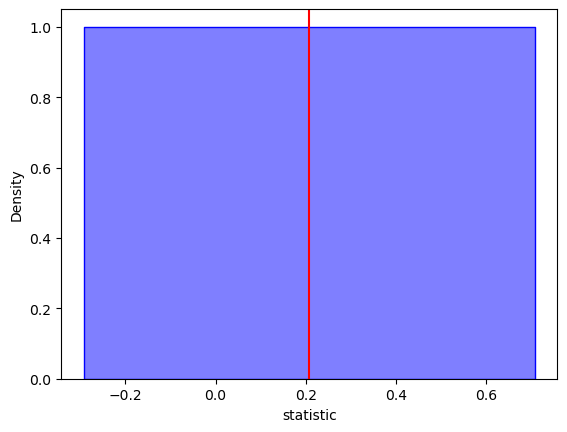

 P value is 1.0
 Orig diff in proportions is 0.21


In [72]:
actual_value = get_buffer_proportion(df)

n_sim = 100

results = pd.DataFrame({'statistic': np.concatenate(([actual_value], np.full(n_sim, np.nan)))})

new_df = df[['MINORPOP_bg_totprop', 'intersect_prop', 'buffer_present']].copy()


for i in range(1, n_sim+1):
    new_df['buffer_present'] = np.random.randint(2, size=len(df))
    results.loc[i, 'statistic'] = get_buffer_proportion(new_df)

pval = (np.abs(results['statistic'] >= actual_value)).mean()

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(results['statistic'], kde=True, color='blue', element='step', stat='density')
plt.axvline(x=actual_value, color='red')
plt.show()
print(f' P value is {pval}')
print(f' Orig diff in proportions is {round(actual_value, 2)}')